# 3) Analyze optimization results and create runs.pkl

After running the model optimizations with the `run_optimizations.py` script, this notebook checks the optimization outputs and it creates a summary file called `runs.pkl` in the `results` folder.

The `runs.pkl` is used in notebook 4 to compare the optimization outputs

In [1]:
import matplotlib.pyplot as plt
import numpy
import os
import pickle
import glob

from pathlib import Path
%matplotlib inline

In [2]:
results_folder = Path('optimization_results/checkpoints')

In [3]:
def read_checkpoint(checkpoint_path):
    """Reads a BluePyOpt checkpoint file"""

    p = Path(checkpoint_path)
    p_tmp = p.with_suffix(p.suffix + ".tmp")

    try:
        run = pickle.load(open(str(p), "rb"))
    except EOFError:
        try:
            run = pickle.load(open(str(p_tmp), "rb"))
        except EOFError:
            logger.error(
                "Cannot store model. Checkpoint file %s does not exist or is corrupted.",
                checkpoint_path,
            )

    return run


def load_checkp(checkpoint_path):
    
    run = read_checkpoint(checkpoint_path)
    
    chkp_name = Path(checkpoint_path).stem

    chkp_name_split = chkp_name.split('_')
    
    model = "hay"
    if "hay_ais" in chkp_name:
        model = "hay_ais"

    feature_set = [e.replace('featureset=', '') for e in chkp_name_split if "featureset=" in e ][0]
    seed = int([e.replace('seed=', '') for e in chkp_name_split if "seed=" in e ][0])

    run = {"nevals": numpy.cumsum(run['logbook'].select("nevals")),
           "population": run['population'],
           "hof": run['halloffame'],
           "logbook": run['logbook'],
           "model": model,
           "seed": seed,
           "feature_set": feature_set,
           "best_fitness": numpy.sum(run['halloffame'][0].fitness.values),
           "best_scores": list(run['halloffame'][0].fitness.values),
           "best_params": list(run['halloffame'][0]),
           "path": path}
    
    return run


In [4]:
runs = []

for path in glob.glob(f"{str(results_folder)}/*"):
    
    if ".tmp" in path or "runs" in path:
        continue
    
    print(path)
    runs.append(load_checkp(path))

optimization_results/checkpoints/model=hay_featureset=extra_seed=5
optimization_results/checkpoints/model=hay_featureset=extra_seed=8
optimization_results/checkpoints/model=hay_featureset=extra_seed=7
optimization_results/checkpoints/model=hay_ais_featureset=extra_seed=7
optimization_results/checkpoints/model=hay_ais_featureset=soma_seed=1
optimization_results/checkpoints/model=hay_ais_featureset=extra_seed=1
optimization_results/checkpoints/model=hay_featureset=soma_seed=1
optimization_results/checkpoints/model=hay_featureset=soma_seed=2
optimization_results/checkpoints/model=hay_ais_featureset=extra_seed=8
optimization_results/checkpoints/model=hay_ais_featureset=soma_seed=5
optimization_results/checkpoints/model=hay_ais_featureset=extra_seed=5
optimization_results/checkpoints/model=hay_ais_featureset=soma_seed=6
optimization_results/checkpoints/model=hay_ais_featureset=extra_seed=4
optimization_results/checkpoints/model=hay_featureset=soma_seed=6
optimization_results/checkpoints/mod

In [5]:
models = set([run["model"] for run in runs])
colors_model = {m: "C{}".format(i) for i,m in enumerate(models)}
print(colors_model)
colors_set = {"extra": "C0", "bap": "C1", "soma": "C2"}

{'hay': 'C0', 'hay_ais': 'C1'}


No handles with labels found to put in legend.


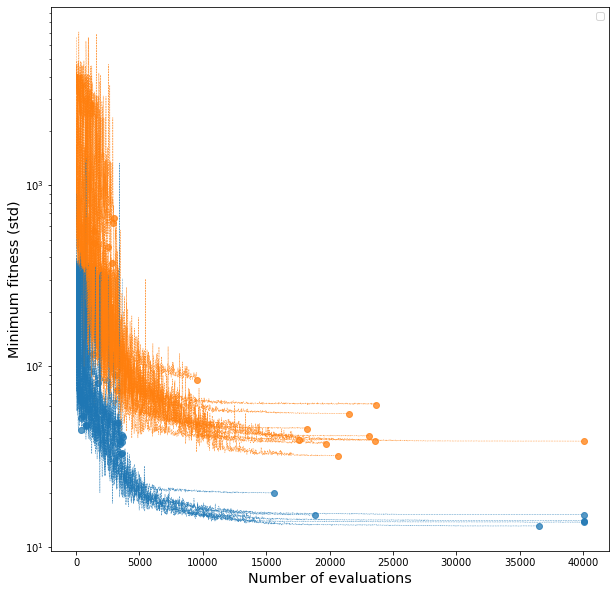

In [6]:
fig, ax = plt.subplots(figsize=(10,10))

for run in runs:

    ax.plot(run["nevals"], 
            run["logbook"].select("min"),
            color=colors_model[run["model"]],
            ls='--', 
            lw=0.5,
            alpha=0.75)
    
    ax.scatter([run["nevals"][-1]], 
               [numpy.sum(run["hof"][0].fitness.values)],
               color=colors_model[run["model"]],
               alpha=0.75)
    
ax.set_xlabel("Number of evaluations", size="x-large")
ax.set_ylabel("Minimum fitness (std)", size="x-large")

ax.set_yscale("log")
#ax.set_ylim(5, 20)
plt.legend()

No handles with labels found to put in legend.


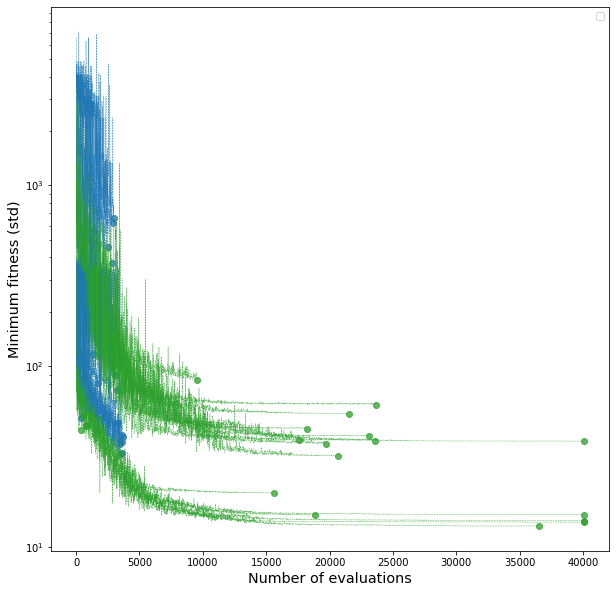

In [7]:
fig, ax = plt.subplots(figsize=(10,10))

for run in runs:

    ax.plot(run["nevals"], 
            run["logbook"].select("min"),
            color=colors_set[run["feature_set"]],
            ls='--', 
            lw=0.5,
            alpha=0.75)
    
    ax.scatter([run["nevals"][-1]], 
               [numpy.sum(run["hof"][0].fitness.values)],
               color=colors_set[run["feature_set"]],
               alpha=0.75)
    
ax.set_xlabel("Number of evaluations", size="x-large")
ax.set_ylabel("Minimum fitness (std)", size="x-large")

ax.set_yscale("log")
#ax.set_ylim(5, 20)
plt.legend()

In [8]:
with open(str(results_folder / "runs.pkl"), 'wb') as fp:
    pickle.dump(runs, fp)

In [9]:
import evaluator

ModuleNotFoundError: No module named 'mpi4py'

In [ ]:
def plot_responses(responses):
    fig, axes = plt.subplots(len(responses), figsize=(10,10))
    for index, (resp_name, response) in enumerate(sorted(responses.items())):
        axes[index].plot(response['time'], response['voltage'], label=resp_name)
        axes[index].set_title(resp_name)
    fig.tight_layout()
    fig.show()

In [ ]:
for run in runs:

    if run["feature_set"] == "soma":

        probe_type = None
        protocols_with_lfp = None
        timeout = 300.
        extra_kwargs = {}

        if run["feature_set"] == "extra":
            probe_type = "planar"
            protocols_with_lfp = ['firepattern_200']
            timeout = 900.

        feature_file = f"../data/{run['model']}_ecode_probe_planar/efeatures/features_BPO_test.json"
        protocol_file = f"../data/{run['model']}_ecode_probe_planar/efeatures/protocols_BPO_test.json"

        eva = evaluator.create_evaluator(
            model_name=run["model"],
            feature_set=run["feature_set"],
            feature_file=feature_file,
            protocol_file=protocol_file,
            probe_type=probe_type,
            protocols_with_lfp=protocols_with_lfp,
            extra_recordings=None,
            timeout=timeout,
            fs=20, 
            fcut=300,
            ms_cut=[2, 10],
            upsample=10
        )
        
        best_params = eva.param_dict(run["best_params"])
        responses = eva.run_protocols(protocols=eva.fitness_protocols.values(), param_values=best_params)
        
        plot_responses(responses)